In [0]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [0]:
# 숫자형 자료형과 object타입의 자료형이 무엇이 있는지 확인한다.

In [6]:
num_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
train[num_cols].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
cat_cols = [col for col in train.columns if train[col].dtype in ['object']]
train[cat_cols].describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Hocking, Mr. Richard George",male,1601,B96 B98,S
freq,1,577,7,4,644


Sex의 unique가 2라는 것으로 부터 Sex는 남녀 둘 중 하나의 값을 가진다. 따라서 label encoding을 진행한다.

Embarked는 세가지 값을 가지고 전체 891개 중 2개가 NaN이다. 2개의 값은 최빈값으로 대체하고 문자를 학습할 수 있는 타입인 int형으로 바꾼다.
Cabin은 891개의 데이터 중에 (891-204)=693개의 데이터가 NaN이다.
NaN데이터가 아닌 값들은 알파벳 대문자 + 숫자의 형태이다.
NaN데이터인 값들을 Z0으로 바꾸고 Cabin열에서 숫자를 삭제한다. 남은 알파벳을 int64타입의 숫자로 바꾼다.

SibSp와 Parch를 합쳐서 Family column을 만들고 SibSp, Parch column을 삭제한다.

Ticket은 난수에 가까운 값이므로 삭제한다.
Name은 Mrs, Mr, Miss 와 같은 호칭만 남기고 삭제한다. 각각의 호칭을 int형의 데이터로 바꾼다.

Fare는 다양한 값을 가지므로 4개의 구간으로 나누고 categorical 타입을 int형으로 바꾼다.

Id는 필요없는 데이터이므로 삭제한다.

In [0]:
def Sex(df):
    df['Sex'] = df.Sex.map({'female':0, 'male':1})
    return df;

def Embarked_fill(df):
    freq_port = train.Embarked.dropna().mode()[0]
    # train의 최빈값을 freq-port라 한다.
    df['Embarked'].fillna(freq_port, inplace = True)
    # df의 NaN값을 freq_port로 바꾼다.
    
    mapping = {"S": 1, "C": 2, "Q": 3}
    df['Embarked'] = df['Embarked'].map(mapping)
    return df

def Cabin_fill(df):
    df['Cabin'].fillna("Z0", inplace = True)
    df['Cabin'] = df.Cabin.str[0]
    return df

def Cabin_convert(df):
    df['Cabin'].fillna("Z0", inplace = True)
    #NaN값을 Z0으로 채운다.
    df['Cabin'] = df.Cabin.str[0]
    #Cabin column의 값을 문자열의 가장 앞의 값(A,B,C,D,E,F,G,T,Z)으로 바꾼다.
    df['Cabin'] = df.Cabin.map({'A': 0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7, 'Z':8})
    df['Cabin'] = df.Cabin.astype(int)
    #문자열 형태의 A,B,C,D,E,F를 int형 숫자로 바꾼다.
    return df

def family(df):
    df['Family'] = df['SibSp'] + df['Parch']
    df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
    return df;

def Name_change(df):
    df.Name = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Name'] = df['Name'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    # 비율이 작은 데이터는 Rare로 바꾼다.

    df['Name'] = df['Name'].replace('Mlle', 'Miss')
    df['Name'] = df['Name'].replace('Ms', 'Miss')
    df['Name'] = df['Name'].replace('Mme', 'Mrs')
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    df['Name'] = df['Name'].map(title_mapping)
    # 공백으로 시작, .으로 끝나는 문자열을 추출한다. 
    return df;

def Age(df):
    #fill
    fill = df.groupby("Name")["Age"].transform('median')
    # Name을 먼저 정리해야 한다.
    df['Age'].fillna(fill, inplace = True)
    df['Age'] = df['Age']+0.5
    df['Age'] = df.Age.astype(int)
    
    #Age group making
    df['Age'] = pd.cut(train['Age'], 8, labels = [1,2,3,4,5,6,7,8])
    df['Age'] = df.Age.astype(int)
    return df
#https://predictors.tistory.com/3 에서 median값으로 채우는 것 참고

def Ticket(df):
    df.drop('Ticket', axis=1, inplace=True)
    #ticket column은 난수에 가까우므로 삭제한다.
    return df


def Fare_group(df):
    df['Fare'] = pd.qcut(df['Fare'], 4, labels = [1,2,3,4])
    # Fare를 네개의 구간으로 나누고 각각의 구간의 라벨을 1,2,3,4로 정한다.
    df['Fare'] = df.Fare.astype(int)
    #categorical 타입이므로 int 타입으로 바꾼다.
    return df

#def Id_drop(df):
#    df.drop('PassengerId', axis = 1, inplace = True)
#    return df

In [0]:
def preprocessing(df):
        df = Sex(df)
        df = Embarked_fill(df)
        df = Cabin_convert(df)
        df = family(df)
        df = Name_change(df)
        df = Age(df)
        df = Ticket(df)
        df = Fare_group(df)
       # df = Id_drop(df)
        return df

In [0]:
train = preprocessing(train)
test = preprocessing(test)

In [11]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Cabin,Embarked,Family
0,1,0,3,1,1,3,1,8,1,1
1,2,1,1,3,0,4,4,2,2,1
2,3,1,3,2,0,3,2,8,1,0
3,4,1,1,3,0,4,4,2,1,1
4,5,0,3,1,1,4,2,8,1,0


In [12]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,Fare,Cabin,Embarked,Family
0,892,3,1,1,3,1,8,3,0
1,893,3,3,0,4,1,8,1,1
2,894,2,1,1,3,2,8,3,0
3,895,3,1,1,4,2,8,1,0
4,896,3,3,0,4,2,8,1,2


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null int64
Sex            891 non-null int64
Age            891 non-null int64
Fare           891 non-null int64
Cabin          891 non-null int64
Embarked       891 non-null int64
Family         891 non-null int64
dtypes: int64(10)
memory usage: 69.7 KB


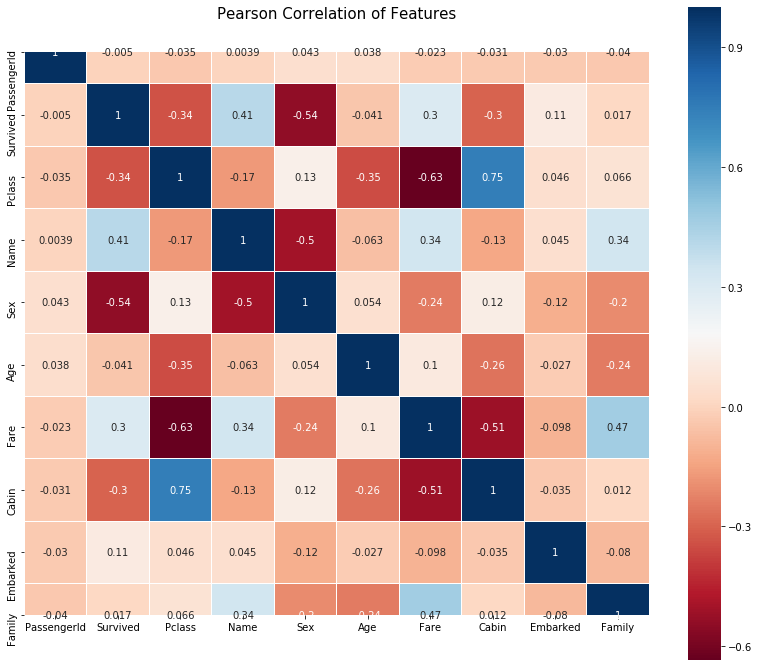

In [14]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [0]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [0]:
input_var=['Pclass','Name','Sex','Age', 'Fare', 'Cabin', 'Embarked','Family']
target=['Survived']

In [0]:
X_train=train[input_var]
y_train=train[target]

In [0]:
num_test = 0.3
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=num_test, random_state=100)

In [19]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)

79.85


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg)

81.34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
# Support Vector Machines
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)
acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc)

83.21


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [22]:
# Linear SVC
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_val)
acc_linear_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_linear_svc)

81.34


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [23]:
# Perceptron
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_val)
acc_perceptron = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_perceptron)

79.48


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)

79.85


In [25]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


80.97


In [26]:
# KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


83.96


In [27]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_val)
acc_sgd = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_sgd)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


81.72


In [28]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(x_train, y_train)
y_pred = gbk.predict(x_val)
acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


85.07


In [29]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier'],
    'Score': [acc_svc, acc_knn, acc_logreg, 
              acc_randomforest, acc_gaussian, acc_perceptron,acc_linear_svc, acc_decisiontree,
              acc_sgd, acc_gbk]})
models.sort_values(by='Score', ascending=False)
# https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner 참고

,Model,Score
9,Gradient Boosting Classifier,85.07
1,KNN,83.96
0,Support Vector Machines,83.21
8,Stochastic Gradient Descent,81.72
2,Logistic Regression,81.34
6,Linear SVC,81.34
3,Random Forest,80.97
4,Naive Bayes,79.85
7,Decision Tree,79.85
5,Perceptron,79.48


In [0]:
# id에 test의 PassengerId를 저장하고 test에서는 해당 column을 삭제한다.
id = test['PassengerId']
test.drop('PassengerId', axis=1, inplace=True)
predictions = gbk.predict(test)

# PassengerId와 Survived를 합친 DataFrame를 만들고 csv파일로 변환한다.
output = pd.DataFrame({ 'PassengerId' : id, 'Survived': predictions })
output.to_csv('submission.csv', index=False)